In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from scipy.fft import fft, ifft

In [93]:
data = pd.read_csv("20230824-Ar-data-run2.csv")
data.head()

,Time (s) Run #1,Current (A) Run #1,Voltage (V) Run #1,ElectronCurrent (10^-10 A) Run #1
0,0.00,2.150000e-13,0.1,0.0
1,0.05,2.061000e-13,0.1,0.0
2,0.10,1.979000e-13,0.1,0.0
3,0.15,2.054000e-13,0.1,0.0
4,0.20,1.974000e-13,0.1,0.0


In [94]:
data.tail()

,Time (s) Run #1,Current (A) Run #1,Voltage (V) Run #1,ElectronCurrent (10^-10 A) Run #1
5451,272.55,-2.659000e-11,85.0,-0.27
5452,272.60,-2.660000e-11,85.0,-0.27
5453,272.65,-2.662000e-11,85.0,-0.27
5454,272.70,-2.665000e-11,85.0,-0.27
5455,272.75,-2.666000e-11,85.0,-0.27


In [95]:
def smooth_data_fourier(data, cutoff_frequency=0.1):
    # Perform FFT
    sp = fft(data)
    
    # Filter out high frequencies
    frequencies = np.fft.fftfreq(len(sp))
    sp[np.abs(frequencies) > cutoff_frequency] = 0
    
    # Perform IFFT
    smoothed_data = np.real(ifft(sp))
    return smoothed_data

In [96]:
voltage = data["Voltage (V) Run #1"].to_numpy()
current = -1 * data["Current (A) Run #1"].to_numpy()

In [97]:
current_smooth = smooth_data_fourier(current[2169:], cutoff_frequency=0.2)
voltage_smooth = voltage[2169:]
index = 0
for i in range(len(voltage_smooth)):
    if voltage_smooth[i]==30.0:
        index = i
print(index)

1115


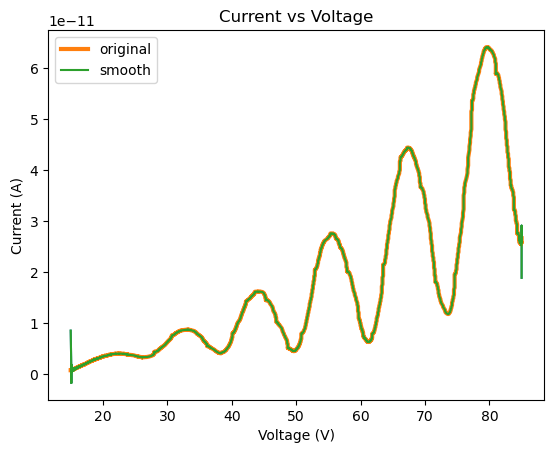

In [134]:
plt.plot(voltage_smooth, current_smooth)

plt.plot(voltage[2169:], current[2169:], lw=3, label="original")
plt.plot(voltage_smooth, current_smooth, lw=1.5, label="smooth")
plt.title("Current vs Voltage")
plt.xlabel("Voltage (V)")
plt.ylabel("Current (A)")
plt.legend()

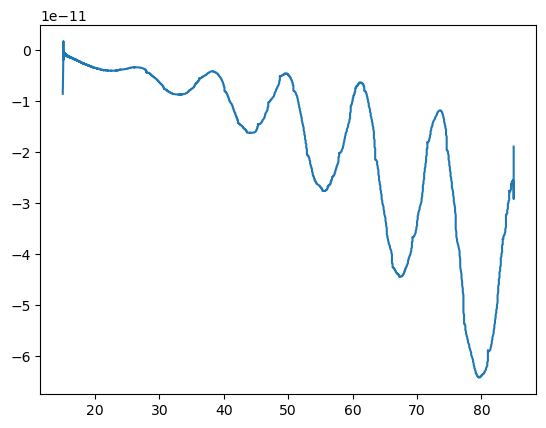

In [99]:
plt.plot(voltage_smooth, -1*current_smooth)

In [100]:
peaks, _ = find_peaks(current_smooth, height=0.4e-11, distance=10, prominence=1e-12)
valleys, _ = find_peaks(-1 * current_smooth, height=-7e-11, distance=15, prominence=1e-12)

peaks = peaks[:-2]
valleys = valleys[:-2]
print(peaks)
print(valleys)
print(len(voltage_smooth))

[1245 1595 2020 2499 2889]
[   2 1372 1781 2256 2692]
3287


In [101]:
voltage_peaks = voltage_smooth[peaks]
voltage_valleys = voltage_smooth[valleys]
current_peaks = current_smooth[peaks]
current_valleys = current_smooth[valleys]

a (Contact Potentials): 11.63, b (First Excitation Potential): 21.030000000000005
a (Contact Potentials): 13.99, b (First Excitation Potential): 5.610000000000011


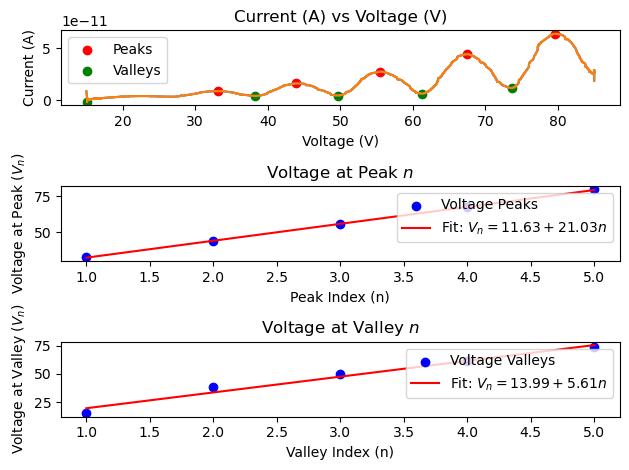

peak number, voltage, current
1 33.2 8.721737439011731e-12
2 43.9 1.6207303005314182e-11
3 55.5 2.7612543014656206e-11
4 67.4 4.444057767550755e-11
5 79.6 6.417699113376992e-11


In [108]:
# Create an array of indices n, starting from 1
n_values = np.arange(1, len(peaks) + 1)

# Perform least squares fit
coefficients = np.polyfit(n_values, voltage_peaks, 1)
a, b = coefficients
print(f"a (Contact Potentials): {a}, b (First Excitation Potential): {b}")

v_coefficients = np.polyfit(n_values, voltage_valleys, 1)
v_a, v_b = v_coefficients
print(f"a (Contact Potentials): {v_a}, b (First Excitation Potential): {v_b}")

# Plot original and smoothed current data
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(voltage_smooth, current_smooth)
plt.scatter(voltage_peaks, current_peaks, color='red', label='Peaks')
plt.plot(voltage_smooth, current_smooth)
plt.scatter(voltage_valleys, current_valleys, color='green', label='Valleys')
plt.title("Current (A) vs Voltage (V)")
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.legend()

# Plot the least squares fit
plt.subplot(3, 1, 2)
plt.scatter(n_values, voltage_peaks, label='Voltage Peaks', color='blue')
fit = np.polyval(coefficients, n_values)
plt.plot(n_values, fit, label=f'Fit: $V_n = {a:.2f} + {b:.2f}n$', color='red')
plt.xlabel('Peak Index (n)')
plt.ylabel('Voltage at Peak ($V_n$)')
plt.title("Voltage at Peak $n$")
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(n_values, voltage_valleys, label='Voltage Valleys', color='blue')
fit = np.polyval(v_coefficients, n_values)
plt.plot(n_values, fit, label=f'Fit: $V_n = {v_a:.2f} + {v_b:.2f}n$', color='red')
plt.xlabel('Valley Index (n)')
plt.ylabel('Voltage at Valley ($V_n$)')
plt.title("Voltage at Valley $n$")
plt.legend()

plt.tight_layout()
plt.show()

print("peak number, voltage, current")
for i in range(len(peaks)):
    print(i+1, voltage_smooth[peaks[i]], current_smooth[peaks[i]])

In [106]:
print("valley number, voltage, current")
for i in range(len(peaks)):
    print(i+1, voltage_smooth[valleys[i]], current_smooth[valleys[i]])

valley number, voltage, current
1 15.1 -1.7206296918200424e-12
2 38.3 4.079654784075301e-12
3 49.7 4.515940729833891e-12
4 61.2 6.300820341076331e-12
5 73.6 1.1783186316388144e-11


In [123]:
print(voltage_smooth[peaks])

[33.2 43.9 55.5 67.4 79.6]


In [132]:
prev = 0
curr = 1
differences_peaks = []
while i < len(voltage_smooth[peaks]) and curr != len(voltage_smooth[peaks]):
    diff = voltage_smooth[peaks][curr] - voltage_smooth[peaks][prev]
    prev += 1
    curr += 1
    differences_peaks.append(diff)
    diff = 0
print(differences_peaks)
differences_peaks = np.array(differences_peaks)
print(np.sum(differences_peaks)/len(differences_peaks))
print(np.std(differences_peaks))

[10.699999999999996, 11.600000000000001, 11.900000000000006, 12.199999999999989]
11.599999999999998
0.5612486080160907


In [133]:
prev = 0
curr = 1
differences_valleys = []
while i < len(voltage_smooth[valleys]) and curr != len(voltage_smooth[valleys]):
    diff = voltage_smooth[valleys][curr] - voltage_smooth[valleys][prev]
    prev += 1
    curr += 1
    differences_valleys.append(diff)
    diff = 0
print(differences_valleys)
differences_valleys = np.array(differences_valleys)
print(np.sum(differences_valleys)/len(differences_valleys))
print(np.std(differences_valleys))

[23.199999999999996, 11.400000000000006, 11.5, 12.399999999999991]
14.624999999999998
4.966072391739772
